In [1]:
import sys
sys.path.append("..")

import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from utils.utils import getHashFromDict, readContentFromFile
from concurrent.futures import ProcessPoolExecutor

In [2]:
EXPERIMENTS_BASE_PATH = "./experiments"

# **No Data Availability Constraint**

In [3]:
traditionalCrossValidationExperimentsPath = f"{EXPERIMENTS_BASE_PATH}/noTransferCrossValidation"

In [4]:
experimentsResults = []
for path in tqdm(glob(f"{traditionalCrossValidationExperimentsPath}/*")):
    experimentId = os.path.basename(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{traditionalCrossValidationExperimentsPath}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{traditionalCrossValidationExperimentsPath}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)
experimentsResultsDF["domain"] = experimentsResultsDF.databasePath.apply(lambda path: os.path.basename(path))

print("Total experiments:", experimentsResultsDF.shape[0])

100%|██████████| 7/7 [00:00<00:00, 39.70it/s]

Total experiments: 7


In [5]:
metricsDF = experimentsResultsDF[["id", "metrics"]].copy()
metricsDF.columns = ["experimentID", "metrics"]
metricsDF["metrics"] = metricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
metricsDF = metricsDF.explode("metrics")
metricsDF["fold"] = metricsDF.metrics.apply(lambda metrics: metrics[0])
metricsDF["metrics"] = metricsDF.metrics.apply(lambda metrics: metrics[1])
metricsDF = pd.concat(
    [metricsDF, metricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
metricsDF = metricsDF.drop(["metrics"], axis = 1)
metricsDF = metricsDF.sort_values("experimentID")
metricsDF = metricsDF.reset_index(drop = True)
metricsDF.head()

,experimentID,fold,threshold,cll,aucROC,aucPR,prec,rec,f1
0,0ab95ef4a1ed652a52b1dd2bb3a7d984906411ff9b026e...,fold00,0.453,-0.459912,0.883175,0.830173,0.880952,0.425287,0.573643
1,0ab95ef4a1ed652a52b1dd2bb3a7d984906411ff9b026e...,fold01,0.484,-0.359560,0.962232,0.923233,0.940299,0.605769,0.736842
2,0ab95ef4a1ed652a52b1dd2bb3a7d984906411ff9b026e...,fold02,0.610,-0.423518,0.975987,0.951686,0.956522,0.239130,0.382609
3,0ab95ef4a1ed652a52b1dd2bb3a7d984906411ff9b026e...,fold03,0.382,-0.395367,0.974175,0.960138,1.000000,0.662791,0.797203
4,134e592f2c35531403b4757f710c6d1d8b6d0e1a80ba79...,fold00,0.472,-0.158166,0.995087,0.989147,0.966942,0.928571,0.947368


In [6]:
experimentsResultsDF["aucROC_mean"] = experimentsResultsDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.mean()
)
experimentsResultsDF["aucROC_std"] = experimentsResultsDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.std()
)
experimentsResultsDF["aucPR_mean"] = experimentsResultsDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.mean()
)
experimentsResultsDF["aucPR_std"] = experimentsResultsDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.std()
)

originalRDNBoostAllFoldsDF = pd.merge(
    experimentsResultsDF,
    metricsDF,
    how = "left",
    left_on = "id",
    right_on = "experimentID"
)

NameError: name 'originalRDNBoostMetricsDF' is not defined

In [19]:
originalRDNBoostPlotDF = pd.melt(
    originalRDNBoostAllFoldsDF, 
    id_vars = ["domain"], 
    value_vars = ["aucROC", "aucPR"], 
    var_name = "metric", 
    value_name = "value"
)
sns.barplot(
    data = originalRDNBoostPlotDF, 
    x = "domain", 
    y = "value", 
    hue = "metric",
    order = ["imdb", "twitter", "nell_sports", "uwcse", "yeast", "nell_finances", "cora"]
)
_ = plt.ylim(0,1)
_ = plt.xlabel("domain")

NameError: name 'originalRDNBoostAllFoldsDF' is not defined

In [ ]:
originalRDNBoostPlotDF.groupby(["domain", "metric"]).agg({"value": lambda group: f"{group.mean():.6f} +- {group.std():.6f}"})

value
domain        metric                      
cora          aucPR   0.609769 +- 0.225051
              aucROC  0.757387 +- 0.189619
imdb          aucPR   1.000000 +- 0.000000
              aucROC  1.000000 +- 0.000000
nell_finances aucPR   0.659174 +- 0.052735
              aucROC  0.744532 +- 0.042768
nell_sports   aucPR   0.983802 +- 0.007076
              aucROC  0.988019 +- 0.004237
twitter       aucPR   0.975301 +- 0.019581
              aucROC  0.988509 +- 0.009303
uwcse         aucPR   0.835462 +- 0.100489
              aucROC  0.933538 +- 0.043130
yeast         aucPR   0.916308 +- 0.059554
              aucROC  0.948892 +- 0.044234

# **Simulating Low-Resource Domain**

In [20]:
crossValidationExperimentsPath = f"{EXPERIMENTS_BASE_PATH}/crossValidation"

In [21]:
def calculateUtility(experimentId, targetUtilityAlphaList):
    foldPredictionPathList = glob(f"{crossValidationExperimentsPath}/{experimentId}/**/aucTemp.txt", recursive = True)
    utilities = []
    for predictionPath in foldPredictionPathList:
        fold = re.findall(r".*(fold[0-9]+).*", predictionPath)[0]
        foldUtilities = []
        for targetUtilityAlpha in targetUtilityAlphaList:
            oneMinusTargetUtilityAlpha = 1 - targetUtilityAlpha
            foldPredictions = readContentFromFile(predictionPath).strip()
            foldPredictions = pd.DataFrame([
                [float(value) for value in instance.split(" ")] for instance in foldPredictions.split("\n")
            ], columns = ["prob", "label"])
            foldPredictions["label"] = foldPredictions.label.astype(int)
            foldPredictions["pmf"] = foldPredictions.apply(lambda row: row.prob if row.label == 1 else (1-row.prob), axis = 1)
            foldPredictions["alphaFairness"] = foldPredictions.pmf.apply(lambda z: np.log(z) if targetUtilityAlpha == 1 else np.power(z,oneMinusTargetUtilityAlpha)/oneMinusTargetUtilityAlpha)
            foldUtility = foldPredictions.alphaFairness.mean()
            foldUtilities.append(foldUtility)
        utilities.append([experimentId, fold, *foldUtilities])
    return pd.DataFrame(data = utilities, columns = ["experimentID", "fold", *[f"utility@targetAlpha_{alpha}" for alpha in targetUtilityAlphaList]])

In [22]:
experimentsResults = []
for path in tqdm(glob(f"{crossValidationExperimentsPath}/*")):
    experimentId = os.path.basename(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{crossValidationExperimentsPath}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{crossValidationExperimentsPath}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)

targetDatabaseDF = experimentsResultsDF["targetDatabase"].apply(pd.Series)
targetDatabaseDF.columns = ["targetDomain", "target_targetPredicate", "target_resetTargetPredicate"]
targetDatabaseDF["targetDomain"] = targetDatabaseDF.targetDomain.apply(lambda databasePath: os.path.basename(databasePath))
sourceDatabaseDF = experimentsResultsDF["sourceDatabase"].apply(pd.Series)
sourceDatabaseDF.columns = ["sourceDomain", "source_targetPredicate", "source_resetTargetPredicate"]
sourceDatabaseDF["sourceDomain"] = sourceDatabaseDF.sourceDomain.apply(lambda databasePath: os.path.basename(databasePath))
metricsDF = experimentsResultsDF["metrics"].apply(pd.Series)
metricsDF.columns = ["metrics_transferLearning", "metrics_originalRDNBoost", "metrics_analogousToOriginalRDNBoost"]

experimentsResultsDF = pd.concat([experimentsResultsDF, targetDatabaseDF, sourceDatabaseDF, metricsDF], axis = 1)
experimentsResultsDF = experimentsResultsDF.drop(["targetDatabase", "sourceDatabase", "metrics", "ignoreSTDOUT"], axis = 1)

columnsToKeep = [
    'id', 'targetDomain', 'target_targetPredicate', 'useRecursion', 'path', 'negPosRatio', 'randomSeed', 
    'maxFailedNegSamplingRetries', 'numberOfClauses', 'numberOfCycles', 'maxTreeDepth', 'nEstimators', 'nodeSize'
]
originalRDNBoostDF = originalRDNBoostDF[columnsToKeep].copy(deep = True)

# experimentsResultsDF["target_targetPredicate"] = experimentsResultsDF.apply(
#     lambda row: re.findall(
#         r"targetPred:\s+(\w.*)/\d+", 
#         readContentFromFile(glob(f"{row.path}/{row.id}/**/train_output.txt", recursive = True)[0])
#     )[0], 
#     axis = 1
# )

print("Total experiments:", experimentsResultsDF.shape[0])

  0%|          | 0/3516 [00:00<?, ?it/s]

100%|██████████| 3516/3516 [01:36<00:00, 36.54it/s]


NameError: name 'originalRDNBoostDF' is not defined

In [ ]:
# experimentIdList = experimentsResultsDF.id.unique().tolist()
# with ProcessPoolExecutor(max_workers = 10) as p:
#     results = list(
#         tqdm(
#             p.map(calculateUtility, experimentIdList, [(0.0,0.3,0.6,1.0,1.3) for i in experimentIdList]), 
#             total=len(experimentIdList)
#         )
#     )

# experimentsUtilitiesDF = pd.concat(results, axis = 0).reset_index(drop = True)
# print(experimentsUtilitiesDF.shape)
# experimentsUtilitiesDF.head()

In [ ]:
experimentsResultsDF.groupby(["sourceDomain", "targetDomain"])[["id"]].count()

id
sourceDomain  targetDomain      
cora          imdb           502
imdb          cora           502
              uwcse          502
nell_finances nell_sports    502
nell_sports   nell_finances  502
twitter       yeast          502
uwcse         imdb             2
yeast         twitter        502

In [7]:
def filterOriginalRDNBoostResultsDF(
    targetDomain = None, 
    target_targetPredicate = None,
):
    df = originalRDNBoostDF.copy()

    if targetDomain:
        df = df[df.targetDomain == targetDomain]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    return df

In [8]:
originalRDNBoostDF = experimentsResultsDF[experimentsResultsDF["runOriginalRDNBoost"] == True].copy(deep = True)

originalRDNBoostMetricsDF = originalRDNBoostDF[["id", "metrics_originalRDNBoost"]].copy()
originalRDNBoostMetricsDF.columns = ["experimentID", "metrics"]
originalRDNBoostMetricsDF["metrics"] = originalRDNBoostMetricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.explode("metrics")
originalRDNBoostMetricsDF["fold"] = originalRDNBoostMetricsDF.metrics.apply(lambda metrics: metrics[0])
originalRDNBoostMetricsDF["metrics"] = originalRDNBoostMetricsDF.metrics.apply(lambda metrics: metrics[1])
originalRDNBoostMetricsDF = pd.concat(
    [originalRDNBoostMetricsDF, originalRDNBoostMetricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.drop(["metrics"], axis = 1)
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.sort_values("experimentID")
originalRDNBoostMetricsDF = originalRDNBoostMetricsDF.reset_index(drop = True)
# originalRDNBoostMetricsDF = pd.merge(
#     originalRDNBoostMetricsDF, 
#     experimentsUtilitiesDF, 
#     on = ["experimentID", "fold"], 
#     how = "left"
# )

columnsToKeep = [
    'id', 'targetDomain', 'target_targetPredicate', 'useRecursion', 'path', 'negPosRatio', 'randomSeed', 
    'maxFailedNegSamplingRetries', 'numberOfClauses', 'numberOfCycles', 'maxTreeDepth', 'nEstimators', 'nodeSize'
]
originalRDNBoostDF = originalRDNBoostDF[columnsToKeep].copy(deep = True)

originalRDNBoostDF["aucROC_mean"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.mean()
)
originalRDNBoostDF["aucROC_std"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucROC.std()
)
originalRDNBoostDF["aucPR_mean"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.mean()
)
originalRDNBoostDF["aucPR_std"] = originalRDNBoostDF["id"].apply(
    lambda expID: originalRDNBoostMetricsDF[originalRDNBoostMetricsDF["experimentID"] == expID].aucPR.std()
)
originalRDNBoostDF = originalRDNBoostDF.drop_duplicates(
    subset = set(originalRDNBoostDF.columns) - set(["id"])
)

originalRDNBoostAllFoldsDF = pd.merge(
    originalRDNBoostDF,
    originalRDNBoostMetricsDF,
    how = "left",
    left_on = "id",
    right_on = "experimentID"
)

KeyError: 'runOriginalRDNBoost'

/tmp/ipykernel_10595/4146008743.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().sort_values("value", ascending = False).index.tolist()


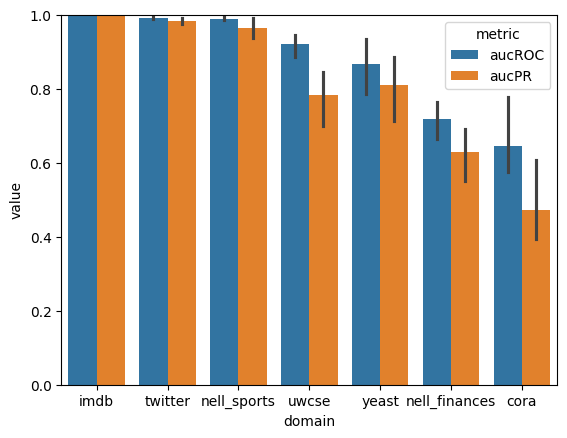

In [ ]:
originalRDNBoostPlotDF = pd.melt(
    originalRDNBoostAllFoldsDF, 
    id_vars = ["targetDomain"], 
    value_vars = ["aucROC", "aucPR"], 
    var_name = "metric", 
    value_name = "value"
)
sns.barplot(
    data = originalRDNBoostPlotDF, 
    x = "targetDomain", 
    y = "value", 
    hue = "metric",
    order = originalRDNBoostPlotDF[originalRDNBoostPlotDF.metric == "aucROC"].groupby(
        ["targetDomain"]
    ).mean().sort_values("value", ascending = False).index.tolist()
)
_ = plt.ylim(0,1)
_ = plt.xlabel("domain")

In [ ]:
originalRDNBoostPlotDF.groupby(["targetDomain", "metric"]).agg({"value": lambda group: f"{group.mean():.6f} +- {group.std():.6f}"})

value
targetDomain  metric                      
cora          aucPR   0.473191 +- 0.151364
              aucROC  0.646198 +- 0.146544
imdb          aucPR   1.000000 +- 0.000000
              aucROC  1.000000 +- 0.000000
nell_finances aucPR   0.628930 +- 0.070847
              aucROC  0.718829 +- 0.051323
nell_sports   aucPR   0.965925 +- 0.026593
              aucROC  0.989048 +- 0.006170
twitter       aucPR   0.982757 +- 0.011079
              aucROC  0.993062 +- 0.003844
uwcse         aucPR   0.783410 +- 0.097891
              aucROC  0.921652 +- 0.040539
yeast         aucPR   0.811415 +- 0.109036
              aucROC  0.867002 +- 0.088602